# **Imports and setup**

In [ ]:
%pip install arch


   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
    -------------------------------------- 20.5/927.1 kB 682.7 kB/s eta 0:00:02
   ------------------------- -------------- 593.9/927.1 kB 7.5 MB/s eta 0:00:01
   --------------------------------------- 927.1/927.1 kB 11.8 MB/s eta 0:00:00


In [2]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random
from arch import arch_model

from lambert import Gaussianize
from preprocess import *
from model import * 

import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

First we start by downloading the data for SP500 from May 2009 -> Dec 2018 as described in the paper

In [5]:
# Get the data for SP500 from May 2009 till Dec 2018 (as in the original paper)
sp500 = yf.download('^GSPC', start='2009-05-01', end='2018-12-31')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


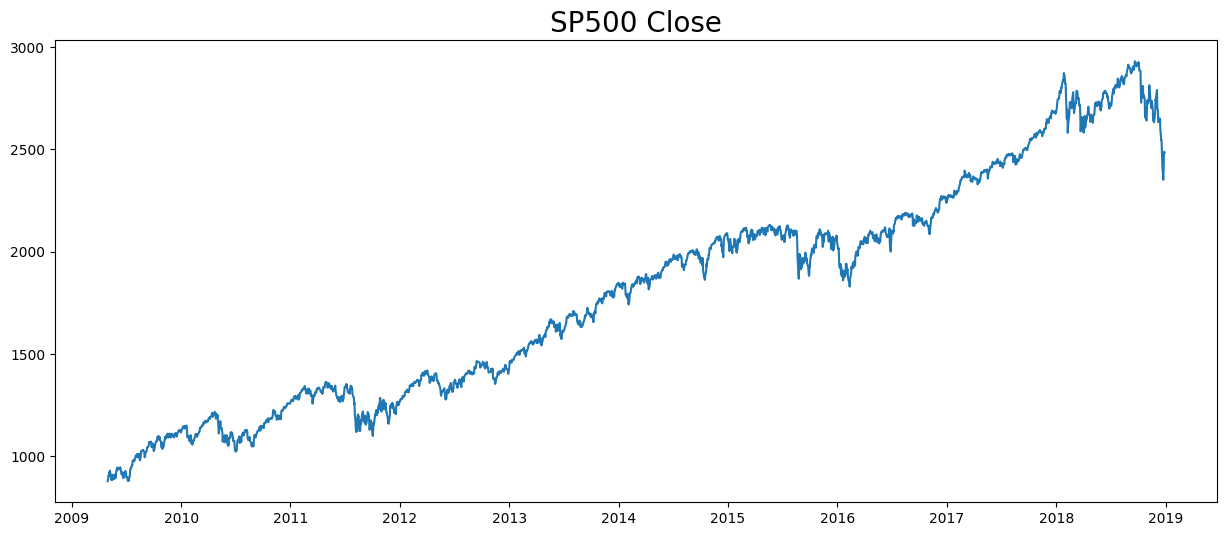

In [3]:
fig = plt.figure(figsize=(15,6))
plt.title('SP500 Close', fontsize=20)
plt.plot(sp500)
plt.show()

## **Preprocessing**

Now we will be going through the following preprocessing pipeline as described in the paper :

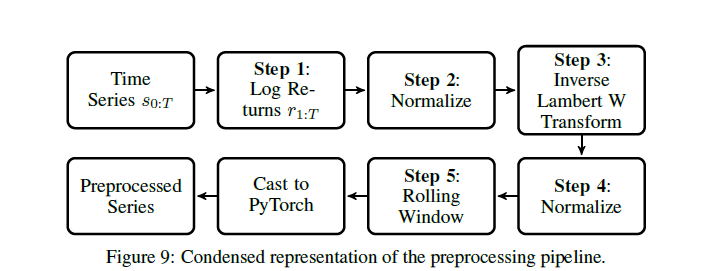

In [4]:
sp500log = np.log(sp500 / sp500.shift(1))[1:].values

In [5]:
normalise_1 = StandardScaler()
log_std_1 = normalise_1.fit_transform(sp500log)

lambertw = Gaussianize()
log_gaussianized = lambertw.fit_transform(log_std_1)

normalise_2 = StandardScaler()
log_returns_preprocessed = normalise_2.fit_transform(log_gaussianized)

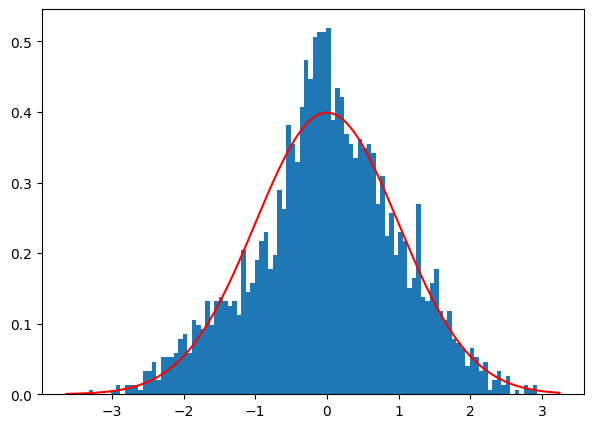

In [8]:
plt.hist(log_returns_preprocessed, bins=100, density=True)
x_axis = np.linspace(plt.xlim(), 2, num=1000)
mu, std = np.mean(log_returns_preprocessed), np.std(log_returns_preprocessed)
plt.plot(x_axis, norm.pdf(x_axis, mu, std), 'r', label='Normal PDF')
plt.show()

We can clearly see that the transformed data is similar to a gaussian distribution !

In [ ]:
log_returns_preprocessed[0:127].reshape(-1,127).shape

(127,1)


(1, 127)

# **DataLoader and Hyperparameters**

In [9]:
print(log_returns_preprocessed.shape[0])

2432


We have 2432 data points

In [ ]:
num_epochs = 100
latent_dim = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 1e-2

class Loader(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __getitem__(self, idx):
        sample = self.data[idx:idx+self.window_size]
        return torch.tensor(sample).reshape(-1,self.window_size).float()

    def __len__(self):
        return len(self.data) - self.window_size

# Dataset et loader
dataset = Loader(log_returns_preprocessed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# **Pure TCN**

We start by building the Pure TCN, whose architecture is defined as follows:

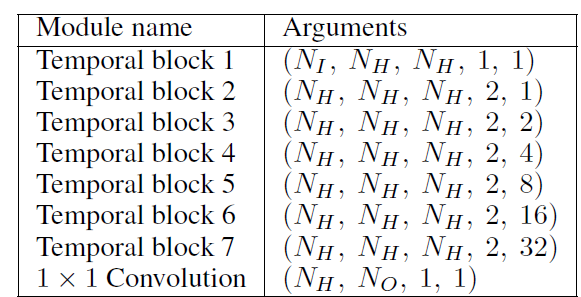

where:

$N_{I}$ (input channels) = 3 for the Generator and 1 for the Discriminator

$N_{H}$ = 80 (hidden channels)

$N_{O}$ = 1

For more details about the generator and discriminator of the Pure TCN model, please refer to the implementation in model.py. 


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator(seq_len).to(device)

You can run the following code to train the GAN. It takes approximately one minute on Google Colab. Alternatively, you can use our pre-trained model provided in the next cell.

In [ ]:
gen_optimizer = optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

t = tqdm(range(num_epochs))
for epoch in t:
    for idx, data in enumerate(dataloader):

        discriminator.zero_grad()
        real = data.to(device)
        noise = torch.randn(real.size(0), latent_dim, real.size(2), device=device)
        fake = generator(noise).detach()
        disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
        disc_loss.backward()
        disc_optimizer.step()

        for dp in discriminator.parameters():
            dp.data.clamp_(-clip, clip)

        if idx % 5 == 0:
            generator.zero_grad()
            gen_loss = -torch.mean(discriminator(generator(noise)))
            gen_loss.backward()
            gen_optimizer.step()


    t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Discriminator Loss: 0.00000000 Generator Loss: -0.50059414: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [ ]:
#torch.save(generator, 'generator.pth')
generator = torch.load('generator.pth')

# Generation

After training the generator, we can now sample synthetic log-returns.

The outputs are then transformed back into the original data space by reversing the preprocessing steps, we also filter the generated samples to remove extreme outliers based on the range of the historical SP500 log-returns.

In [ ]:
generator.eval()
noise = torch.randn(80,3,2500).to(device)
y = generator(noise).cpu().detach().squeeze()

# Inverse transformations of the generated data
y = (y - y.mean(axis=0))/y.std(axis=0)
y = normalise_2.inverse_transform(y)
y = np.array([lambertw.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = normalise_1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * sp500log.max()) & (y.min(axis=1) >= 2 * sp500log.min())]
y -= y.mean()

49

## Results and visualizing stylized facts

We then reproduce the results presented in the appendices.

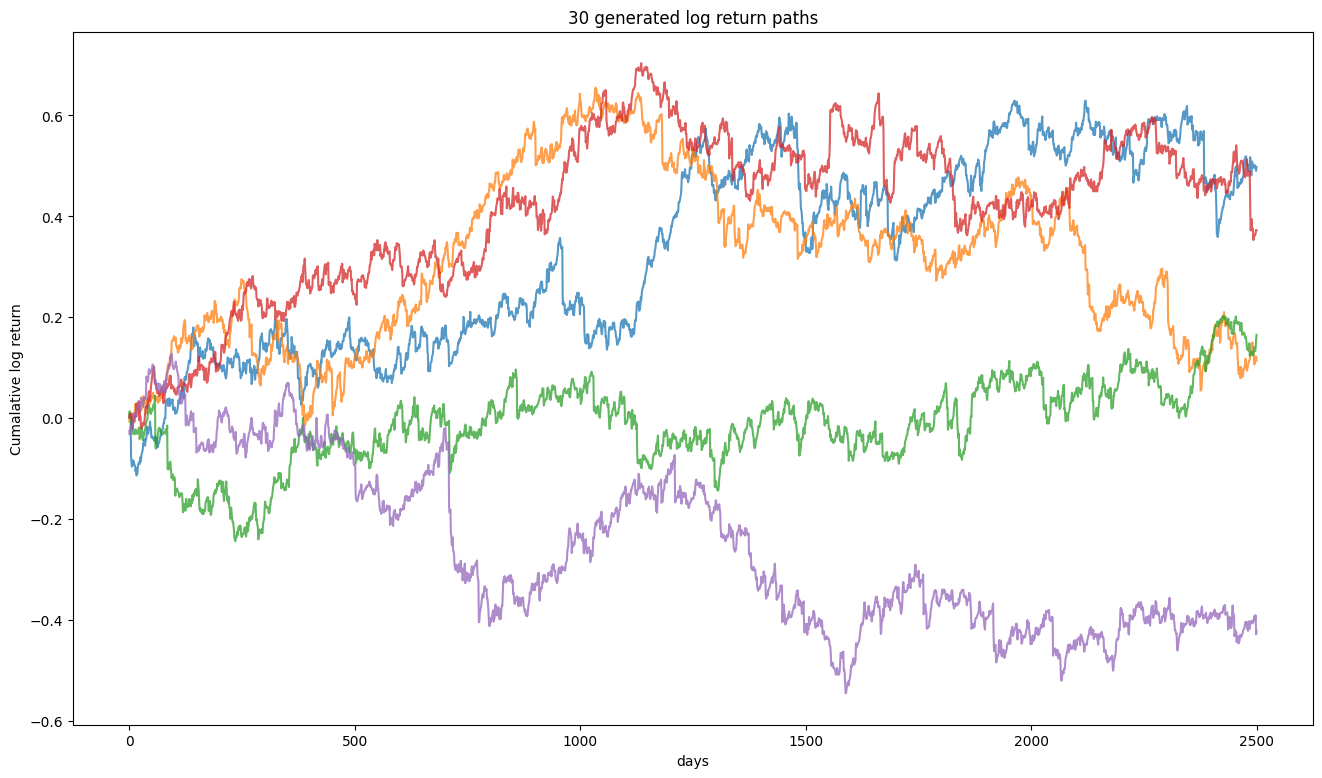

In [53]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:5], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

NameError: name 'y' is not defined

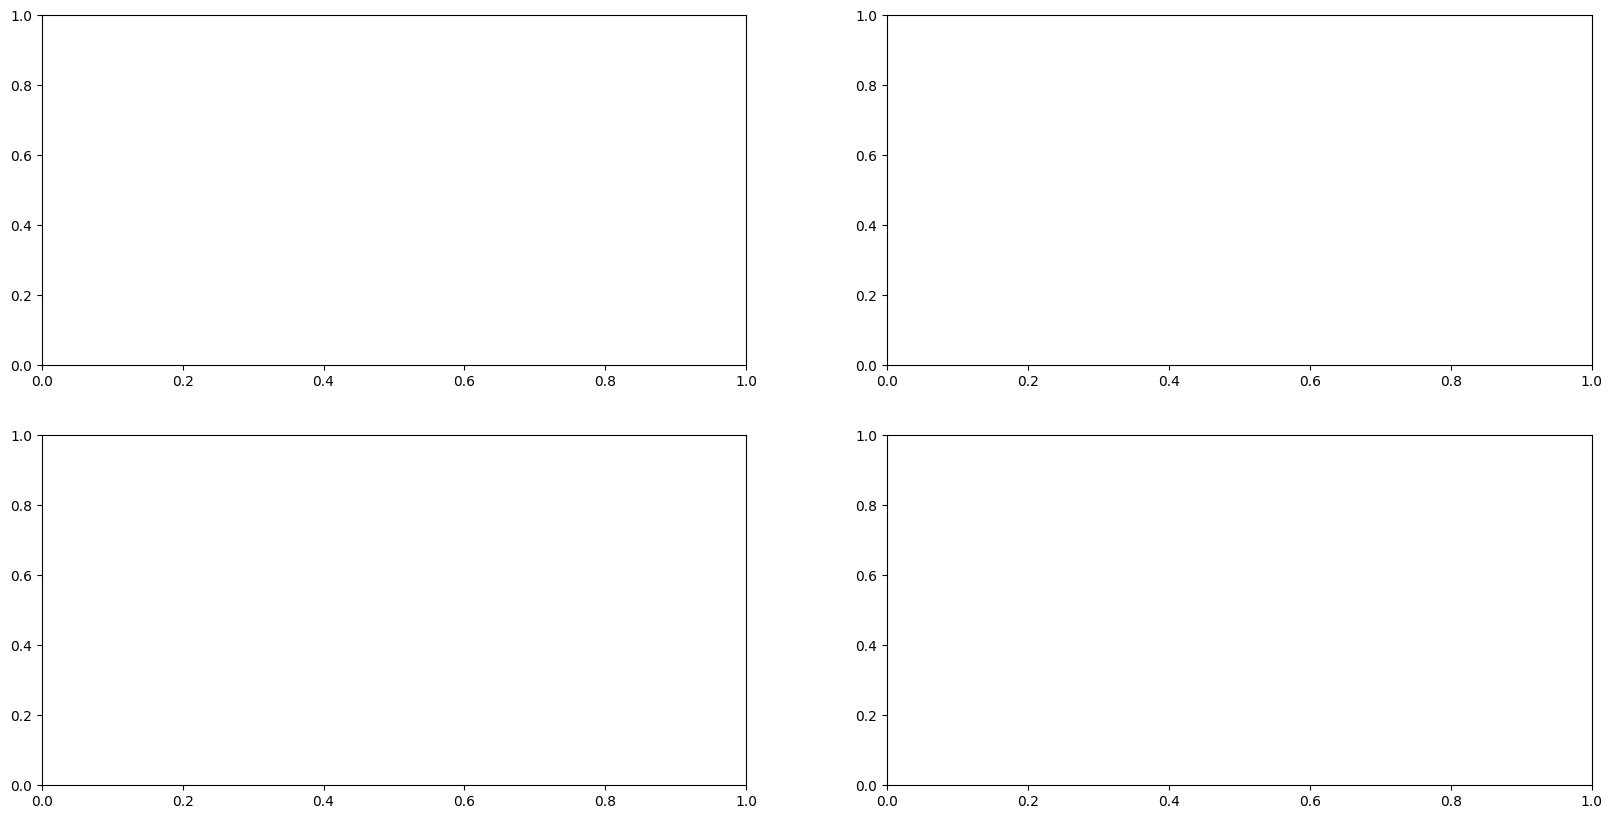

In [ ]:
n_bins = 100
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(sp500log, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

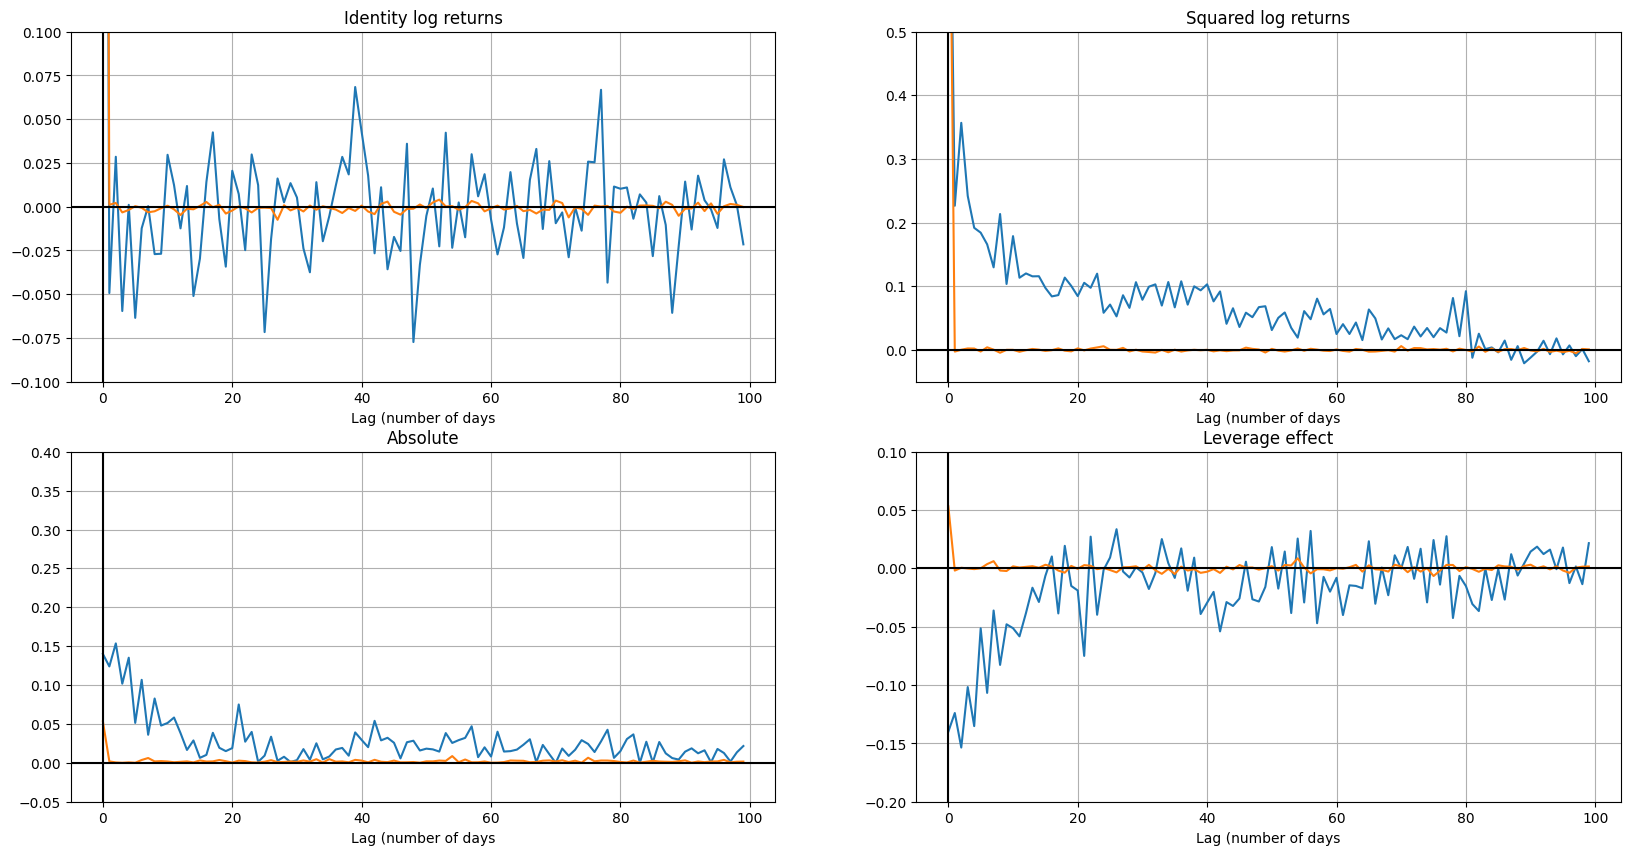

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(sp500log, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(sp500log**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(sp500log, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(sp500log, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

# **C-SVNN**

Now we will be working with the C-SVNN, which its architecture is as follows: 


where:

$N_{I}$ (input channels) = 3 for the Generator and 1 for the Discriminator

$N_{H}$ (hidden channels) = 80  

$N_{O}$ = 2 for the Generator and 1 for the Discriminator

For more details about the generator and the discriminator of the pure TCN, please refer to the code in model.py. 

The discriminator architecture of the SVNN remains the same as the discriminator of the pure TCN.

We redo the preprocessing of the data so we can apply again the inverse function after

In [18]:
normalise_1 = StandardScaler()
log_std_1 = normalise_1.fit_transform(sp500log)

lambertw = Gaussianize()
log_gaussianized = lambertw.fit_transform(log_std_1)

normalise_2 = StandardScaler()
log_returns_preprocessed = normalise_2.fit_transform(log_gaussianized)

In [ ]:
generator = CSVNNGenerator().to(device)
discriminator = Discriminator(seq_len=seq_len-1).to(device)  # ATTENTION: seq_len-1 here, for more details refer to the models' code !

You can run the following code to train the C-SVNN, it takes around 1 minute on google colab or you can use our pre-trained model in the next cell

In [ ]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    for i, real_samples in enumerate(dataloader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        noise = torch.randn(batch_size, latent_dim, seq_len).to(device)

        discriminator.zero_grad()

        sigma, mu, epsilon = generator(noise)  # (batch_size, seq_len-1) each
        fake_returns = sigma * epsilon + mu  # (batch_size, seq_len-1)

        real_returns = real_samples.squeeze(1)[:, :-1]  # Remove the last element to match the fake shape (batch_size, seq_len-1)

        # Reshaping to match the discriminator input shape
        real_input = real_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)
        fake_input = fake_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)

        loss_D = -torch.mean(discriminator(real_input)) + torch.mean(discriminator(fake_input))
        loss_D.backward()
        optimizer_D.step()

        # Clipping des poids (WGAN)
        for p in discriminator.parameters():
            p.data.clamp_(-clip, clip)

        if i % 5 == 0:
            optimizer_G.zero_grad()

            sigma, mu, epsilon = generator(noise)
            fake_returns = sigma * epsilon + mu
            fake_input = fake_returns.unsqueeze(1)  # (batch_size, 1, seq_len-1)

            loss_G = -torch.mean(discriminator(fake_input))
            loss_G.backward()
            optimizer_G.step()

    pbar.set_description(f"Epoch {epoch}: D Loss {loss_D.item():.4f}, G Loss {loss_G.item():.4f}")


Epoch 99: D Loss -0.0001, G Loss -0.5005: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


In [ ]:
torch.save(generator, 'svnn_generator.pth')
generator = torch.load('svnn_generator.pth')

# Generation

After training the generator, we can now sample synthetic log-returns.

The outputs are then transformed back into the original data space by reversing the preprocessing steps, we also filter the generated samples to remove extreme outliers based on the range of the historical SP500 log-returns.

In [ ]:
generator.eval()

noise = torch.randn(80, 3, 2500).to(device)

with torch.no_grad():
    sigma, mu, epsilon = generator(noise)  # chacun (80, 2499) car 2500-1

# Simulate returns
y = sigma * epsilon + mu  # (80, 2499)

# inverse transformations of the generated data
y = (y - y.mean(dim=1, keepdim=True)) / y.std(dim=1, keepdim=True)  # normaliser chaque série

y = y.cpu().numpy()
y = normalise_2.inverse_transform(y)
y = np.array([lambertw.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = normalise_1.inverse_transform(y)

# some basic filtering to reduce the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * sp500log.max()) & (y.min(axis=1) >= 2 * sp500log.min())]
y -= y.mean()

print("Number of kept trajectories :", len(y))

Nombre de trajectoires retenues : 36


## Results and visualizing stylized facts

We then reproduce the results presented in the appendices.

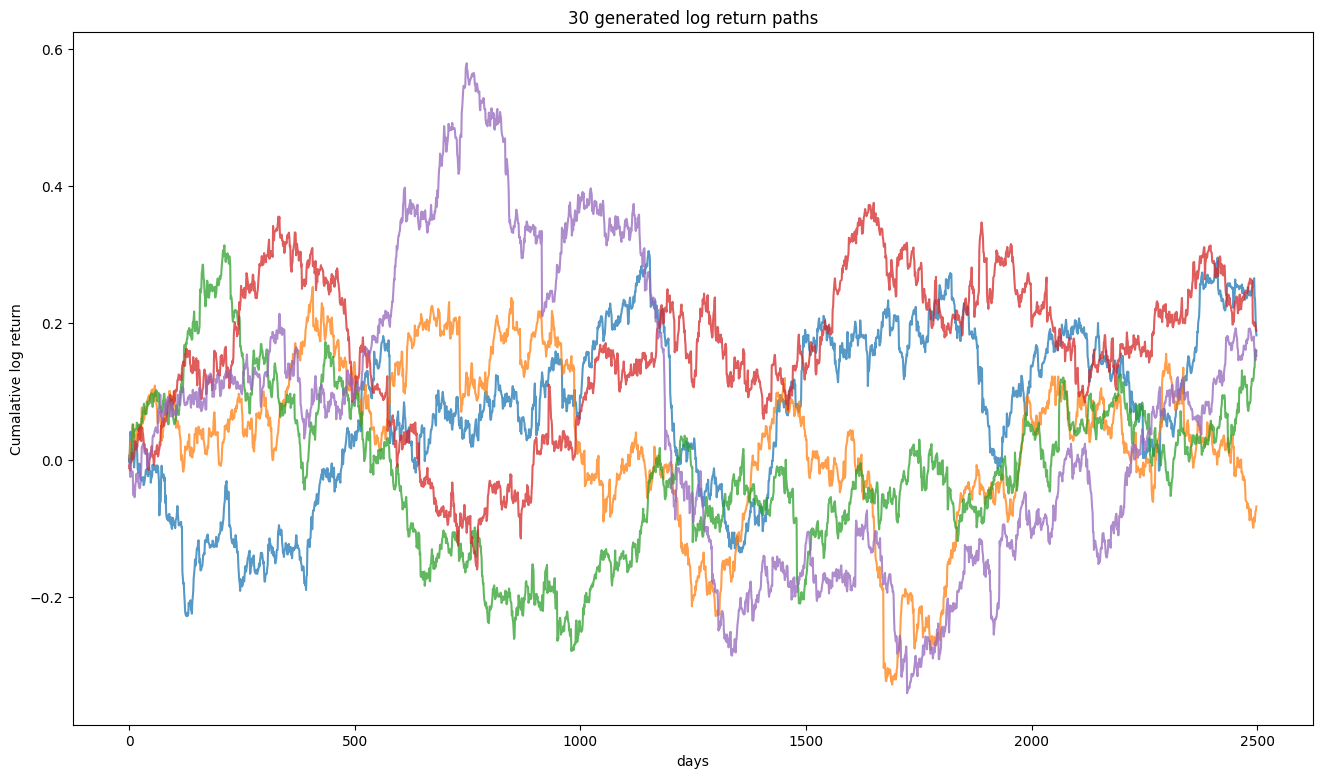

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

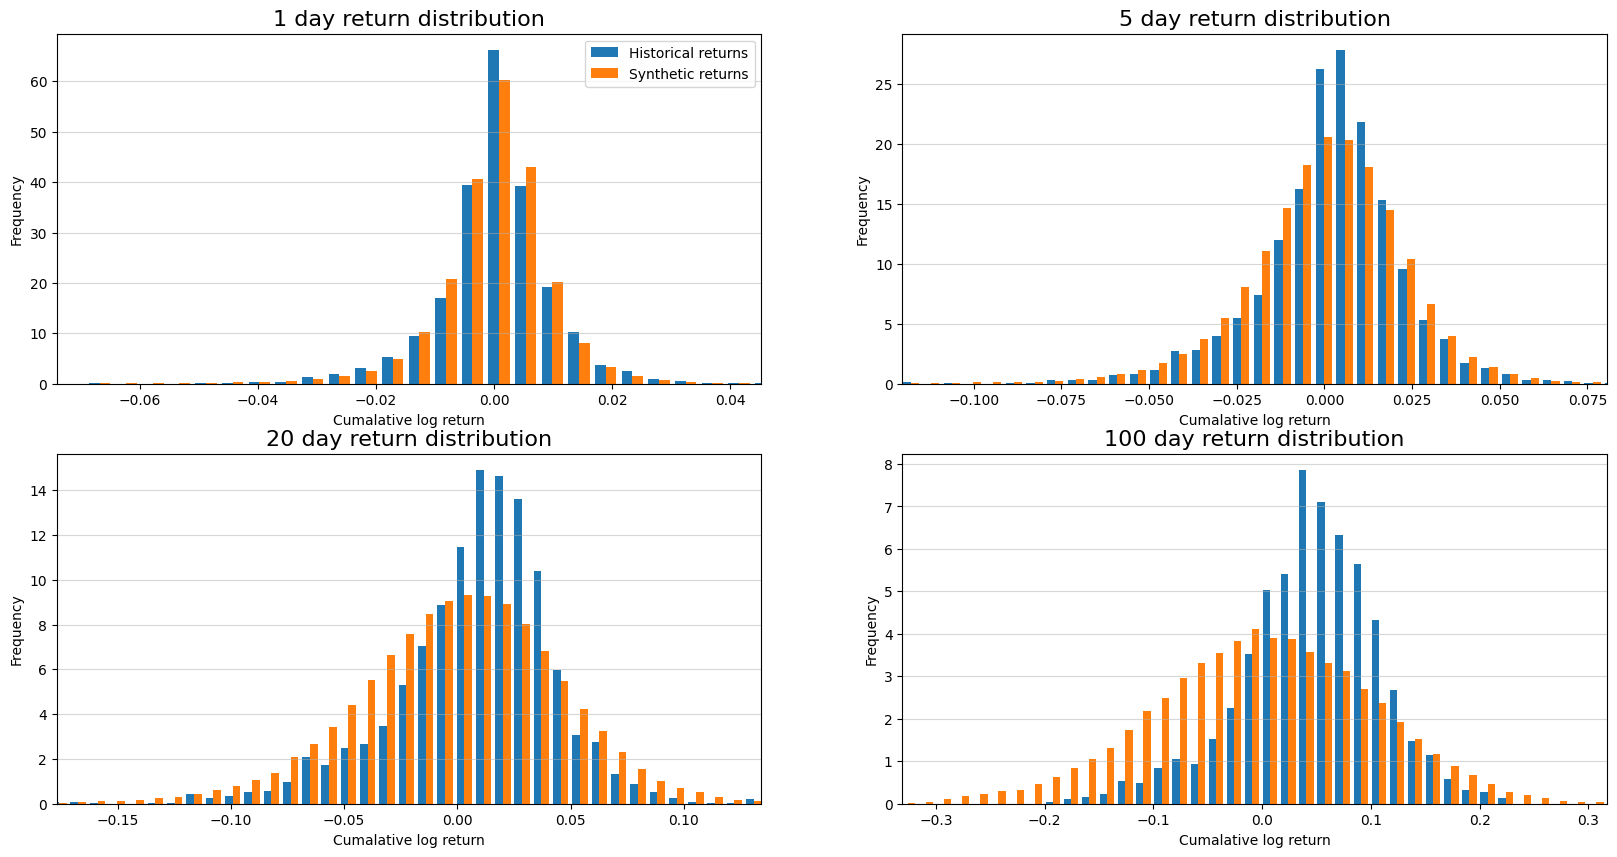

In [52]:
n_bins = 100
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(sp500log, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

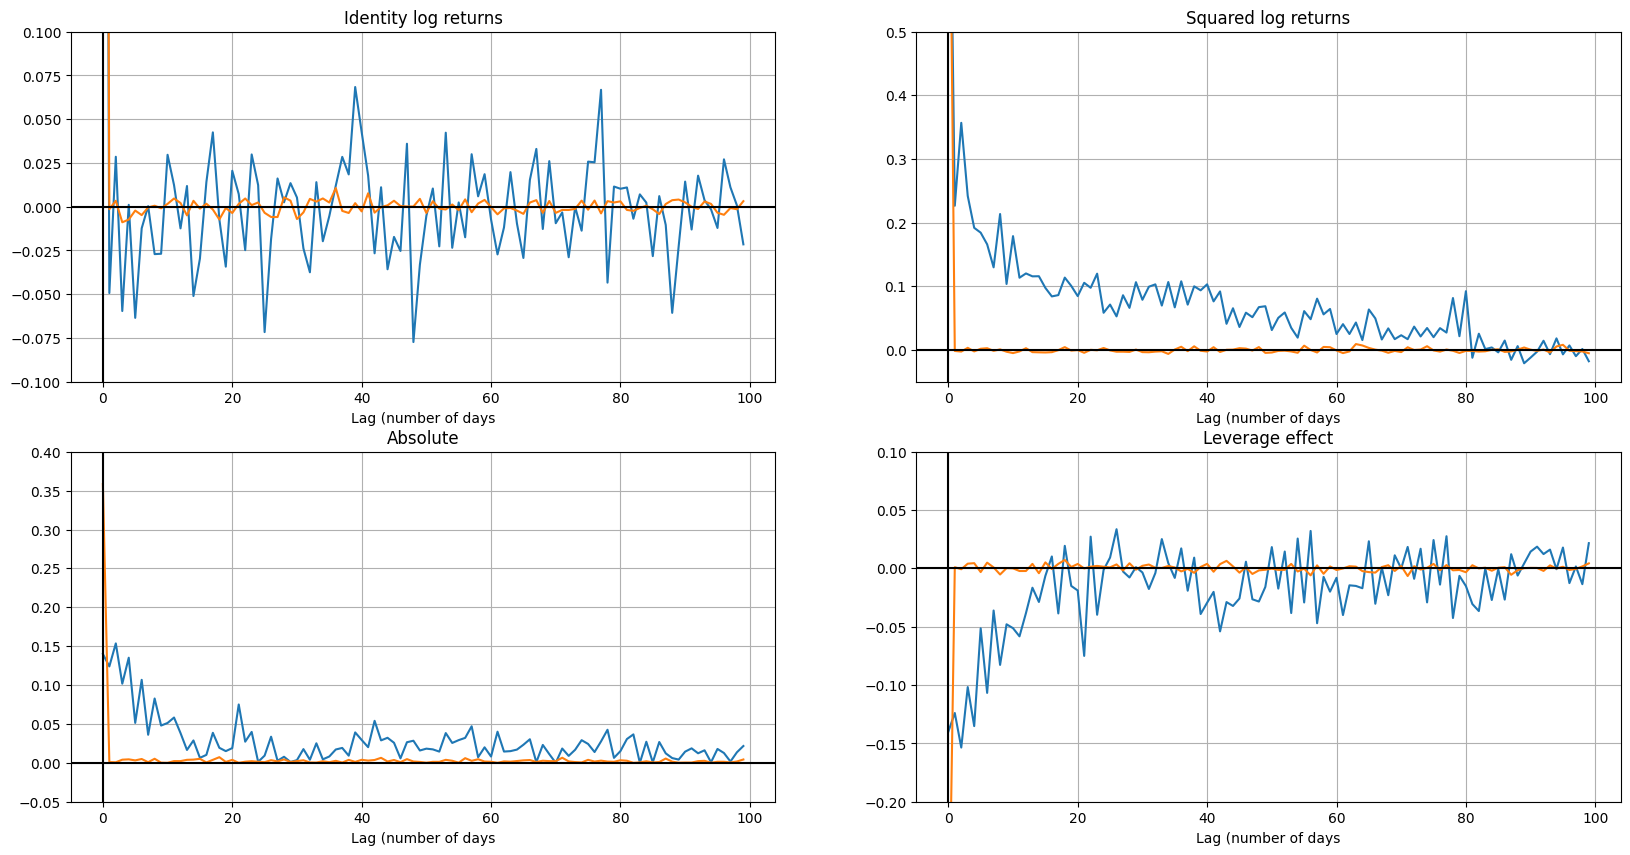

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(sp500log, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(sp500log**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(sp500log, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(sp500log, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

# **GARCH (1,1)**

As in the paper we compare our results with the GARCH(1,1) model

We start by fitting a GARCH(1,1) model to our s&p data

In [6]:
# Ensure correct 1D shape
sp500 = sp500.squeeze()  
log_returns = np.diff(np.log(sp500.values), axis=0)

print(log_returns.shape)  # (2432,)

# 3. Fit GARCH(1,1)
am = arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal')
res = am.fit(disp='off')

# 4. Print fitted parameters
res.summary()

(2432,)


c:\Users\tahah\anaconda3\envs\riemann\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.338e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8190.57
Distribution:                  Normal   AIC:                          -16373.1
Method:            Maximum Likelihood   BIC:                          -16349.9
                                        No. Observations:                 2432
Date:                Sun, Apr 27 2025   Df Residuals:                     2431
Time:                        23:52:14   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.8085e-04  4.969e-06    137.006      0.000 [6.711e-04,6.906e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8688e-06  8.023e-13  2.329e+06      0.000 [1.869e-06,1.869e-06]
alpha[1]       0.1000  1.743e-02      5.736  9.686e-09   [6.583e-02,  0.134]
beta[1]        0.8800  1.461e-02     60.232      0.000     [  0.851,  0.909]
============================================================================

Covariance estimator: robust
"""

Once our model is fitted on the data, we simulate some returns

In [7]:
# Simulate from the fitted model 
n_simulations = 50
horizon = 2000

simulated_paths = []

for _ in range(n_simulations):
    sim_data = am.simulate(res.params, nobs=horizon)
    returns_sim = sim_data['data']  # simulated returns
    price_sim = np.exp(np.cumsum(returns_sim))  # cumulative returns -> prices
    simulated_paths.append(price_sim)

simulated_paths = np.array(simulated_paths)
print(simulated_paths.shape) # (50, 2000)

(50, 2000)


In [8]:
# Real data
real_log_prices = np.log(sp500.values.squeeze())  
real_log_returns = np.diff(real_log_prices)      

# GARCH simulated data
garch_log_prices = np.log(simulated_paths)       
garch_log_returns = np.diff(garch_log_prices, axis=1)

# Generation

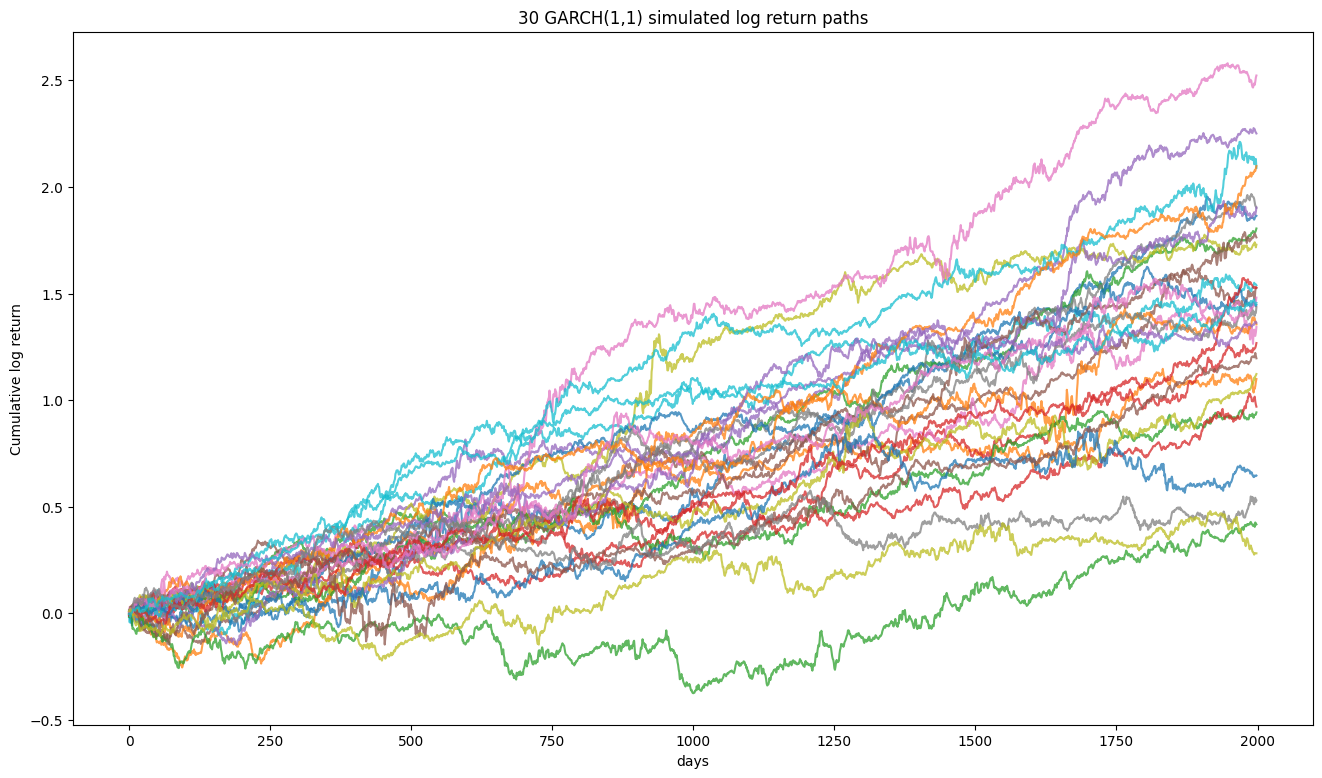

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(garch_log_returns[:30], axis=1).T, alpha=0.75)
ax.set_title('30 GARCH(1,1) simulated log return paths')
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return');

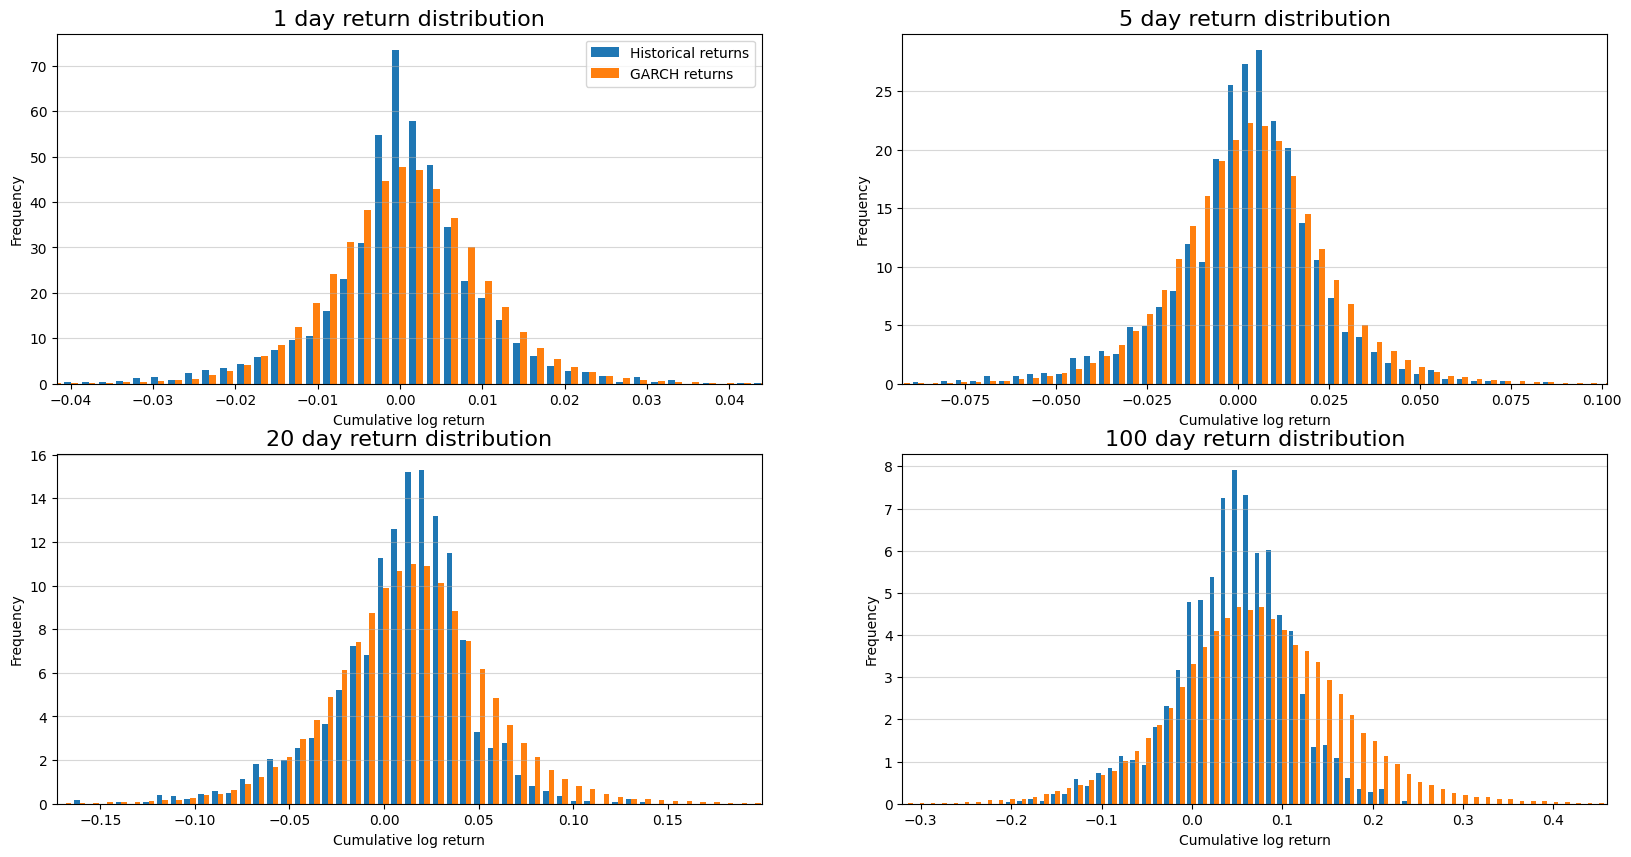

In [10]:
n_bins = 100
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(real_log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    garch_dist = rolling_window(garch_log_returns.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, garch_dist], dtype='object'), bins=n_bins, density=True)
    axs[row,col].set_xlim(*np.quantile(garch_dist, [0.001, .999]))
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'GARCH returns'])

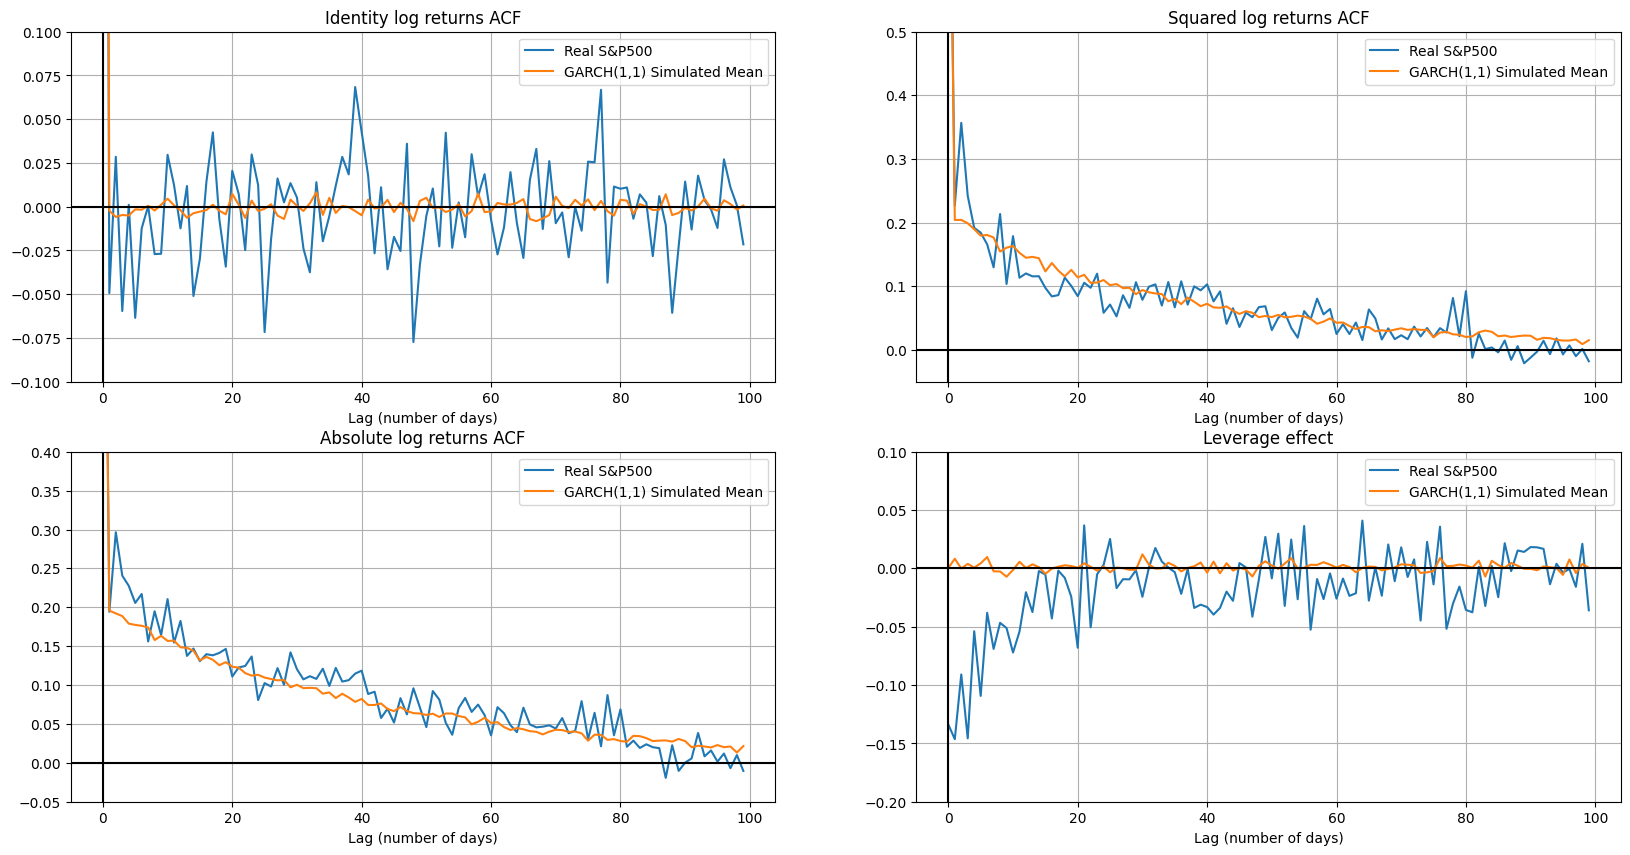

In [11]:
# Compute ACFs for GARCH paths
garch_acfs_identity = []
garch_acfs_squared = []
garch_acfs_absolute = []
garch_leverage_effect = []

nlags = 100

for i in range(garch_log_returns.shape[0]):
    returns = garch_log_returns[i]

    # Identity (plain returns)
    garch_acfs_identity.append(acf(returns, nlags))

    # Squared returns
    garch_acfs_squared.append(acf(returns**2, nlags))

    # Absolute returns
    garch_acfs_absolute.append(acf(np.abs(returns), nlags))

    # Leverage effect: corr(r_t, |r_{t+k}|)
    lev = []
    for lag in range(1, nlags+1):
        if lag < len(returns):
            corr = np.corrcoef(returns[:-lag], np.abs(returns[lag:]))[0,1]
            lev.append(corr)
        else:
            lev.append(np.nan)
    garch_leverage_effect.append(lev)

# Convert lists to arrays and average across paths
garch_acfs_identity = np.mean(np.stack(garch_acfs_identity), axis=0)
garch_acfs_squared = np.mean(np.stack(garch_acfs_squared), axis=0)
garch_acfs_absolute = np.mean(np.stack(garch_acfs_absolute), axis=0)
garch_leverage_effect = np.nanmean(np.stack(garch_leverage_effect), axis=0)

# Now plot everything
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# 1. Identity returns ACF
axs[0,0].plot(acf(real_log_returns, nlags), label="Real S&P500")
axs[0,0].plot(garch_acfs_identity, label="GARCH(1,1) Simulated Mean")
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns ACF')
axs[0,0].legend()

# 2. Squared returns ACF
axs[0,1].plot(acf(real_log_returns**2, nlags), label="Real S&P500")
axs[0,1].plot(garch_acfs_squared, label="GARCH(1,1) Simulated Mean")
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].set_title('Squared log returns ACF')
axs[0,1].legend()

# 3. Absolute returns ACF
axs[1,0].plot(acf(np.abs(real_log_returns), nlags), label="Real S&P500")
axs[1,0].plot(garch_acfs_absolute, label="GARCH(1,1) Simulated Mean")
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute log returns ACF')
axs[1,0].legend()

# 4. Leverage effect
# For real returns
real_leverage = []
for lag in range(1, nlags+1):
    if lag < len(real_log_returns):
        corr = np.corrcoef(real_log_returns[:-lag], np.abs(real_log_returns[lag:]))[0,1]
        real_leverage.append(corr)
    else:
        real_leverage.append(np.nan)

axs[1,1].plot(real_leverage, label="Real S&P500")
axs[1,1].plot(garch_leverage_effect, label="GARCH(1,1) Simulated Mean")
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')
axs[1,1].legend()

# Finishing touches
for ax in axs.flat:
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

plt.setp(axs, xlabel='Lag (number of days)')
plt.show()